In [117]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,8)

from itertools import combinations
import researchpy as rp

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OrdinalEncoder
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_columns = None 

In [118]:
df = pd.read_pickle('../data/cardio_risk.pkl')
df.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,,
0,64.0,2.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,221.0,148.0,85.0,28.0,90.0,80.0,1.0
1,36.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,212.0,168.0,98.0,30.0,72.0,75.0,0.0
2,46.0,1.0,1.0,1.0,10.0,0.0,0.0,0.0,0.0,250.0,116.0,71.0,20.0,88.0,94.0,0.0
3,50.0,1.0,0.0,1.0,20.0,0.0,0.0,1.0,0.0,233.0,158.0,88.0,28.0,68.0,94.0,1.0
4,64.0,1.0,1.0,1.0,30.0,0.0,0.0,0.0,0.0,241.0,136.5,85.0,26.0,70.0,77.0,0.0


In [119]:
df_num = pd.read_pickle('../data/df_num.pkl')
df_cat = pd.read_pickle('../data/df_cat.pkl')

In our initial exploration, we found that the variables systolic blood pressure (sysBP) and diastolic blood pressure (diaBP) were strongly correlated. For our predictive model, we eliminate one of them. Due to medical studies indicating that sysBP is a more relevant risk factor for developing coronary heart disease, we will remove the variable diaBP.

In [120]:
df.drop(['diaBP'], axis = 1, inplace = True)
df_num.drop(['diaBP'], axis = 1, inplace = True)

#### FEATURE SCALING
----
We have several outliers, so we use the RobustScaler approach.

In [121]:
robust = RobustScaler()
robust.fit(df_num)
X_robust = robust.transform(df_num)

RobustScaler()

In [122]:
numeric_robust = pd.DataFrame(X_robust, columns = df_num.columns)
numeric_robust.head(2)

,age,cigsPerDay,totChol,sysBP,BMI,heartRate,glucose
0,1.071429,0.15,-0.224138,0.722222,0.6,1.0,0.142857
1,-0.928571,0.00,-0.379310,1.462963,1.0,-0.2,-0.214286


In [123]:
df[numeric_robust.columns] = numeric_robust
df.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,
0,1.071429,2.0,1.0,1.0,0.15,0.0,0.0,0.0,0.0,-0.224138,0.722222,0.6,1.000000,0.142857,1.0
1,-0.928571,4.0,0.0,0.0,0.00,0.0,0.0,1.0,0.0,-0.379310,1.462963,1.0,-0.200000,-0.214286,0.0
2,-0.214286,1.0,1.0,1.0,0.50,0.0,0.0,0.0,0.0,0.275862,-0.462963,-1.0,0.866667,1.142857,0.0
3,0.071429,1.0,0.0,1.0,1.00,0.0,0.0,1.0,0.0,-0.017241,1.092593,0.6,-0.466667,1.142857,1.0
4,1.071429,1.0,1.0,1.0,1.50,0.0,0.0,0.0,0.0,0.120690,0.296296,0.2,-0.333333,-0.071429,0.0


#### ENCODING
----
We investigate the correlation between categorical variables and the response variable to ascertain whether they impact the response variable, assigning them Ordinality accordingly.

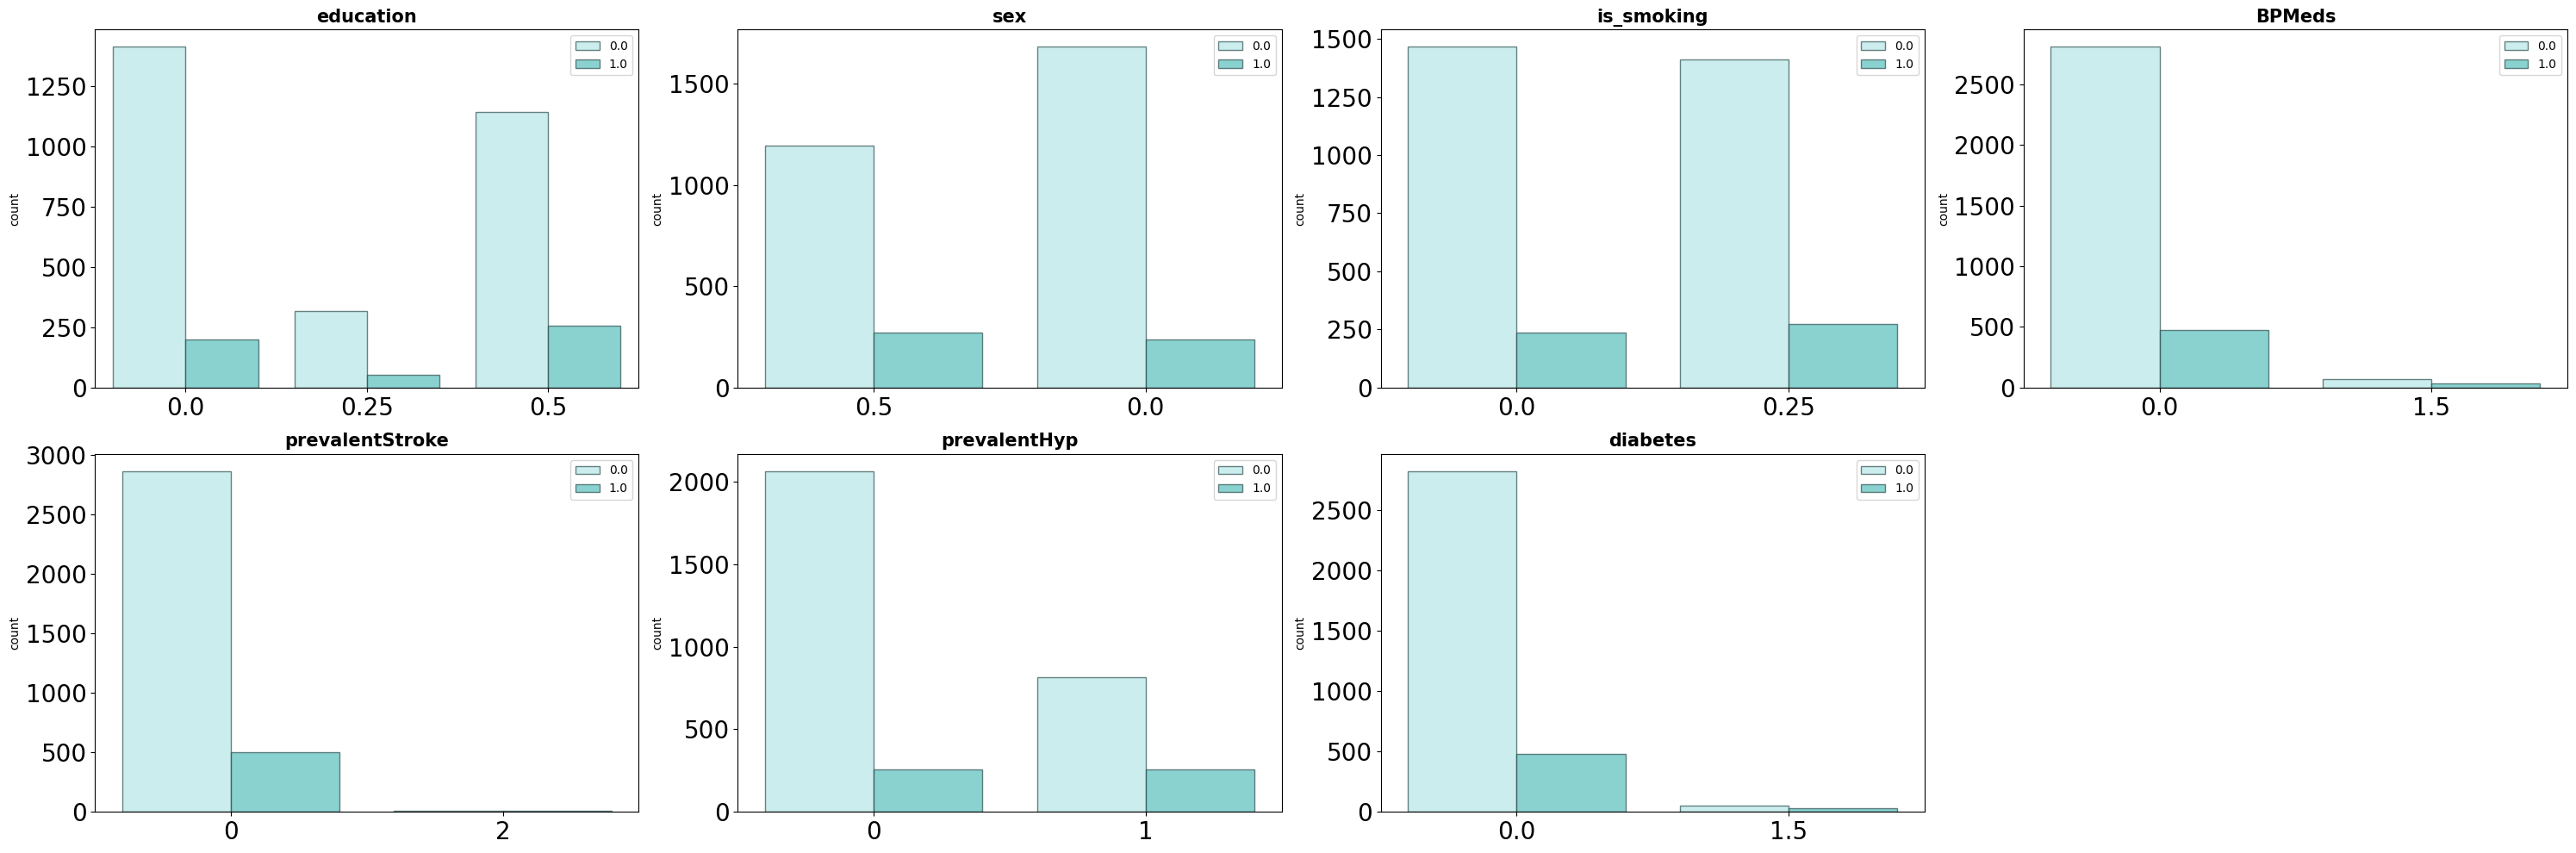

In [132]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (30, 10))
axes = axes.flat

my_palette_1 = ['paleturquoise', 'mediumturquoise']

for index, colum in enumerate(df_cat): 
    sns.countplot(
        data = df,
        x = colum,
        hue = 'TenYearCHD',
        alpha = 0.7, 
        palette = my_palette_1,
        edgecolor = 'darkslategrey',
        ax = axes[index])
    
    axes[index].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[index].tick_params(labelsize = 20)
    axes[index].set_xlabel("")
    axes[index].legend(loc= "upper right")

fig.delaxes(axes[-1])
fig.tight_layout();

In [125]:
# We examine the correlation between categorical variables and the response variable.

for col in df_cat.columns:
    crosstab= rp.crosstab(df_cat[col], df['TenYearCHD'], prop = 'row')
        
    display(crosstab)

TenYearCHD              
TenYearCHD        0.0    1.0    All
education                          
1.0             81.61  18.39  100.0
2.0             87.82  12.18  100.0
3.0             87.39  12.61  100.0
4.0             85.52  14.48  100.0
All             84.93  15.07  100.0

TenYearCHD              
TenYearCHD        0.0    1.0    All
sex                                
0.0             81.46  18.54  100.0
1.0             87.57  12.43  100.0
All             84.93  15.07  100.0

TenYearCHD              
TenYearCHD        0.0    1.0    All
is_smoking                         
0.0             86.14  13.86  100.0
1.0             83.70  16.30  100.0
All             84.93  15.07  100.0

TenYearCHD              
TenYearCHD        0.0    1.0    All
BPMeds                             
0.0             85.47  14.53  100.0
1.0             67.00  33.00  100.0
All             84.93  15.07  100.0

TenYearCHD              
TenYearCHD             0.0    1.0    All
prevalentStroke                         
0.0                  85.12  14.88  100.0
1.0                  54.55  45.45  100.0
All                  84.93  15.07  100.0

TenYearCHD              
TenYearCHD          0.0    1.0    All
prevalentHyp                         
0.0               88.97  11.03  100.0
1.0               76.15  23.85  100.0
All               84.93  15.07  100.0

TenYearCHD              
TenYearCHD        0.0    1.0    All
diabetes                           
0.0             85.53  14.47  100.0
1.0             62.07  37.93  100.0
All             84.93  15.07  100.0

In [126]:
dict_education = {3.0: 0, 2.0: 0, 4.0: 0.25, 1.0: 0.5}
dict_sex = {1.0: 0, 0.0: 0.5}
dict_is_smoking = {0.0: 0, 1.0: 0.25}
dict_bpmeds = {0.0: 0, 1.0: 1.5}
dict_prevalentstroke = {0.0: 0, 1.0: 2}
dict_prevalenthyp = {0.0: 0, 1.0: 1}
dict_diabetes = {0.0: 0, 1.0: 1.5}

In [127]:
dict_map = {'education': dict_education, 'sex': dict_sex, 'is_smoking': dict_is_smoking, 'BPMeds': dict_bpmeds,
            'prevalentStroke': dict_prevalentstroke, 'prevalentHyp': dict_prevalenthyp, 'diabetes': dict_diabetes}

for column, order in dict_map.items():
    df[column] = df[column].map(order)

#### RESAMPLING FOR CLASS IMBALANCE CORRECTION

-----

To address the class imbalance in our dataset, we employ the TokenSMOKE method.

In [128]:
# To apply this method, we first need to separate the data into X and Y, and split it into training and testing sets.
y = df['TenYearCHD']
X = df.drop('TenYearCHD', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [129]:
# We apply the method.
os_us = SMOTETomek()

X_train_resample, y_train_resample = os_us.fit_resample(X_train, y_train)

In [130]:
y_train.value_counts()
y_train_resample.value_counts()

TenYearCHD
0.0    2028
1.0     345
Name: count, dtype: int64

TenYearCHD
0.0    2017
1.0    2017
Name: count, dtype: int64

In [131]:
df.to_pickle('../data/cardio_processed.pkl')